# **Local Orientation and Local Phase**

In this notebook we will explore concepts of local orientation and local phase in images. These are two key concepts that will allows us to develop advanced image processing techniques with applications such as:

- Motion Analysis
- Edge Detection
- Texture Analysis
- Image Data Compression
- Image Enhancement
- Medical Imaging
- Satellite/Hyperspectral Imaging
- Synthetic Aperture radar

## **LOCAL**

The keyword here is LOCAL, this means that we are going to investigate small portions of an image and determine the phase $\theta$ and orientation $\phi$. Now let's define what we mean by phase and orientation:

**local phase** describes the transition of intensities, the overall change from *light to dark* or *dark to light* within a window

**local orientation** describes the angle of the strongest edge in a given window

In [403]:
import numpy as np
import cv2
from skimage.data import camera
import matplotlib.pyplot as plt
%matplotlib inline

In [515]:
g = lambda r : np.sin((112*np.pi)/(np.log(2)*((2**(-r/56))) - 2**(-256/56)))


def f(r):
    """ Vectorized version """
    outputs = r.copy()

    index_1 = (r > 56) & (r <= 64)
    index_2 = (r > 64) & (r <= 224)
    index_3 = (r > 224) & (r <= 256)

    outputs[r <= 56] = 127
    outputs[index_1] = 127 * (1 + g(r[index_1]) * np.cos((np.pi*r[index_1]/16) - 4*np.pi)**2)
    outputs[index_2] = 127*(1 + g(r[index_2]))
    outputs[index_3] = 127*(1 + g(r[index_3]) * np.sin((np.pi*r[index_3]/64) - 4*np.pi)**2)
    outputs[r > 256] = 127

    return outputs


def get_test_image(N):
    x_index, y_index = np.meshgrid(np.arange(0, N), np.arange(0, N))
    x_index = x_index.reshape((-1, 1))
    y_index = y_index.reshape((-1, 1))

    # get radius r
    r = np.round(np.sqrt((x_index - N//2)**2 + (y_index - N//2)**2)).astype(int).squeeze()

    return f(r).astype(np.uint8).reshape((N, N))

In [516]:
N = 512

test_image = get_test_image(N)

test_image = f(r).astype(np.uint8).reshape((N, N))

# add noise
# test_image += np.random.randint(0, 5, size=test_image.shape).astype(np.uint8)

In [517]:
# or use camera as test image
# test_image = camera()

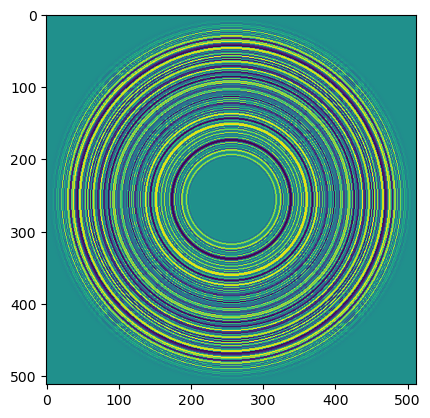

In [518]:
plt.imshow(test_image);

In [496]:
Ix = cv2.Sobel(test_image, -1, 1, 0, ksize=5)
Iy = cv2.Sobel(test_image, -1, 0, 1, ksize=5)

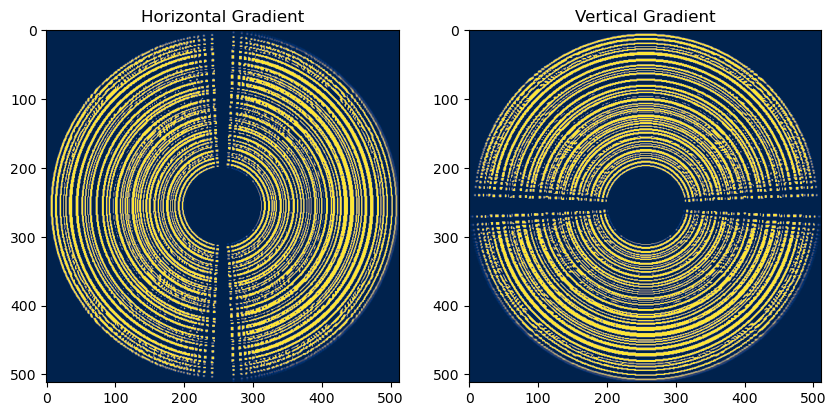

In [497]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(Ix, cmap='cividis')
ax[0].set_title("Horizontal Gradient")
ax[1].imshow(Iy, cmap='cividis')
ax[1].set_title("Vertical Gradient");

In [487]:
# rotation angle of the gradient
phase = np.arctan2(Iy.astype(np.float32), Ix.astype(np.float32))

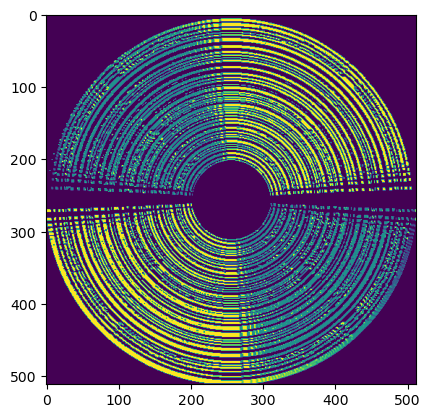

In [488]:
plt.imshow(phase);

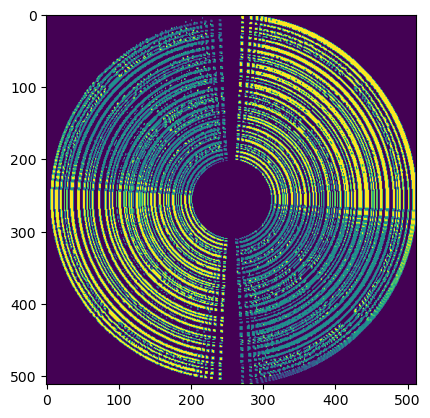

In [489]:
# orientation of the strongest edge at a point
plt.imshow(np.arctan2(Ix, Iy))

### Orientation Vector Map

We can also create an orientation vector map using local horizontal and vertical gradients

In [490]:
from sklearn.decomposition import PCA

pca = PCA(2)

In [491]:
win_sz = 5 # window size
canvas = np.zeros_like(test_image, dtype=np.uint8) # canvas

win_range = np.arange(0, N, win_sz)

for y in win_range:
    for x in win_range:
        # get window
        I = test_image[x:x + win_sz, y:y + win_sz]

        # get local gradients
        Ix = cv2.Sobel(I, None, 1, 0)
        Iy = cv2.Sobel(I, None, 0, 1)

        # get orientation
        arr = np.vstack((Ix.flatten(), Iy.flatten())).T
        arr = (arr - arr.mean(axis=0))/(arr.std(axis=0) + 1e-6)
        pca.fit_transform(arr);

        # draw orientation vector on canvas
        p1, p2 = (pca.components_[0, :] * win_sz//2).astype(int)
        # p11, p22 = (pca.components_[1, :] * win_sz//2).astype(int)
        xc = x+(win_sz//2)
        yc = y+(win_sz//2)
        # cv2.line(canvas, pt1=(yc, xc), pt2=(yc+p2, xc+p1), color=255, thickness=1)
        cv2.arrowedLine(canvas, (yc, xc), (yc+p1, xc+p2), color=255, thickness=1)


c:\Users\itber\anaconda3\Lib\site-packages\sklearn\decomposition\_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
c:\Users\itber\anaconda3\Lib\site-packages\sklearn\decomposition\_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
c:\Users\itber\anaconda3\Lib\site-packages\sklearn\decomposition\_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
c:\Users\itber\anaconda3\Lib\site-packages\sklearn\decomposition\_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
c:\Users\itber\anaconda3\Lib\site-packages\sklearn\decomposition\_pca.py:543: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var
c:\Users\itber\anaconda3\Lib\site-packag

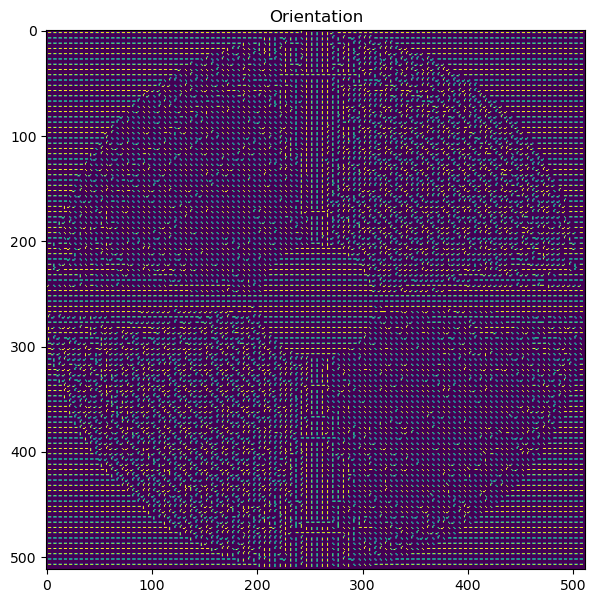

In [492]:
plt.figure(figsize=(7,7))
plt.imshow(canvas);
plt.title("Orientation");

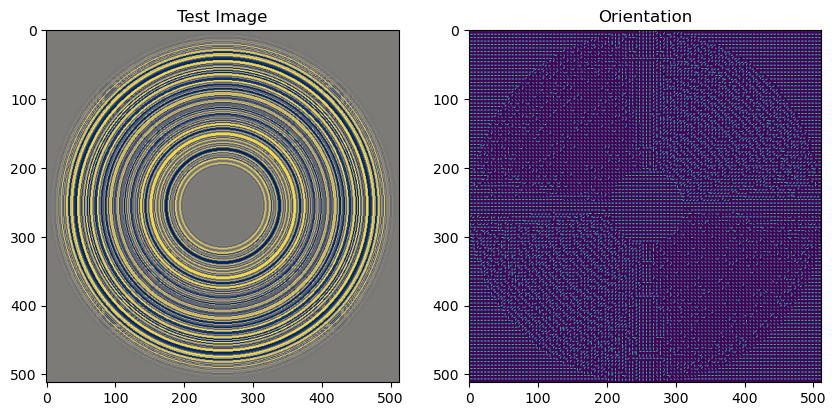

In [493]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(test_image, cmap='cividis')
ax[0].set_title("Test Image")
ax[1].imshow(canvas)
ax[1].set_title("Orientation");